# Построение модели для предсказания цены машины

**По подготовленным на занятии данным, создайте обучающую, тестовую и проверочную выборки.**

По сформированным данным необходимо обучить модель для предсказания цены машины. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода:

```python
predict_inverse = y_scaler.inverse_transfrom(predict).flatten()
```

где `predict` - результат предсказания модели).

Затем подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.

Рекмендации:

- В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- Метрику для данной задачи можно не использовать.
- Последний слой модели должен иметь 1 нейрон.

In [1]:
from pathlib import Path
import sys
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable

Отобразить список доступных устройств.

In [3]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


get_available_gpus()

[]

Задать количество эпох для обучения.

In [4]:
EPOCHS = 20

В качестве метрики качества должна быть использована метрика MAPE, определяемая следующим образом:

$$
\mathrm{MAPE} = \frac 1n \sum_{i=1}^n \left|\frac {y_i - y'_i}{y_i}\right|,
$$

где $y_i$ - фактическое значение, а $y'_i$ - предсказанное значение.

Определим функцию для нахождения заданной метрики качества:

In [5]:
def mean_absolute_percentage_error(
    y_true: np.ndarray, 
    y_pred: np.ndarray
) -> Tuple[float, np.ndarray]:
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    percentage = 100 * np.abs((y_true - y_pred) / (y_true + 1e-15))

    return float(np.mean(percentage)), percentage

## Подготовка данных

Определить путь для загрузки датасета.

In [6]:
path = Path.cwd().parent.parent / 'data' / 'datasets' / '02-cars-new' / 'cars_new.csv'

Выполнить загрузку датасета.

In [7]:
df = pd.read_csv(path)
df.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


Отобразить размер загруженных данных.

In [8]:
print(df.shape)

(70119, 10)


Выделить числовые признаки набора данных.

In [9]:
numeric = df[['year', 'mileage', 'volume', 'power']]
numeric.head()

,year,mileage,volume,power
0,2018,28000,2.0,150.0
1,2012,60500,1.5,80.0
2,2011,29000,1.3,85.0
3,2014,49500,2.0,150.0
4,2007,151445,1.4,95.0


Выполнить масштабирование числовых признаков.

In [11]:
numeric_scaler = StandardScaler()

scaled = pd.DataFrame(
    data=numeric_scaler.fit_transform(numeric),
    index=numeric.index,
    columns=['year', 'mileage', 'volume', 'power']
)
scaled.head()

,year,mileage,volume,power
0,1.520015,-1.400182,0.122885,0.229056
1,0.673314,-1.061187,-0.622106,-0.956303
2,0.532198,-1.389751,-0.920102,-0.871635
3,0.955548,-1.175924,0.122885,0.229056
4,-0.032269,-0.112573,-0.771104,-0.702298


Выделить категориальные атрибуты.

In [12]:
categorical = df[['mark', 'model', 'body', 'kpp', 'fuel']]
categorical.head()

,mark,model,body,kpp,fuel
0,kia,cerato,седан,автомат,бензин
1,daewoo,nexia 1 поколение [2-й рестайлинг],седан,механика,бензин
2,suzuki,jimny 3 поколение [рестайлинг],внедорожник,автомат,бензин
3,bmw,x1 18 e84 [рестайлинг],кроссовер,автомат,бензин
4,chevrolet,lacetti 1 поколение,седан,механика,бензин


Выполнить бинарное кодирование категориальных данных.

In [13]:
encoded = pd.get_dummies(categorical)
encoded.head()

,mark_audi,mark_bmw,mark_chery,mark_chevrolet,mark_daewoo,mark_ford,mark_honda,mark_hyundai,mark_kia,mark_mazda,...,body_хетчбэк,kpp_автомат,kpp_вариатор,kpp_механика,kpp_робот,fuel_бензин,fuel_газ,fuel_гибрид,fuel_дизель,fuel_электро
0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


Объединить числовые и категориальные атрибуты.

In [14]:
data = pd.concat([scaled, encoded], axis=1)
data.head()

,year,mileage,volume,power,mark_audi,mark_bmw,mark_chery,mark_chevrolet,mark_daewoo,mark_ford,...,body_хетчбэк,kpp_автомат,kpp_вариатор,kpp_механика,kpp_робот,fuel_бензин,fuel_газ,fuel_гибрид,fuel_дизель,fuel_электро
0,1.520015,-1.400182,0.122885,0.229056,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0.673314,-1.061187,-0.622106,-0.956303,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0.532198,-1.389751,-0.920102,-0.871635,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0.955548,-1.175924,0.122885,0.229056,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,-0.032269,-0.112573,-0.771104,-0.702298,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


Отобразить размер обработанных данных.

In [15]:
print(data.shape)

(70119, 3206)


Выделить тестовую выборку.

In [16]:
x, x_test, y, y_test = train_test_split(
    data, 
    df['price'], 
    test_size=0.2,
    shuffle=True
)

Отобразить размер тестовой выборки.

In [17]:
print(f"Test set: {x_test.shape}, {y_test.shape}")

Test size: (14024, 3206), (14024,)


Выделить обучающую и валидационную выборки.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.25,
    shuffle=True
)

Отобразить размеры обучающей и валидационной выборок.

In [20]:
print(f"Train set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")

Train set: (42071, 3206), (42071,)
Validation set: (14024, 3206), (14024,)


## Создание нейронной сети

Вспомогательный класс для создания нейронной сети.

In [21]:
class NetBuilder:

    @staticmethod
    def build(
        layers: Tuple[int, ...],
        dropout_rate=0.5
    ) -> Sequential:

        if not layers or not isinstance(layers, Iterable) or not layers:
            raise RuntimeError(f"Illegal layers collection {layers}")

        model = Sequential()
        for idx, n in enumerate(layers):
            if n <= 0:
                raise RuntimeError(f"Illegal number of the neurons {n}")
                
            if idx == 0:
                model.add(Dense(n, input_dim=data.shape[1]))
            else:
                model.add(Dense(n))

            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='linear'))

        model.compile(
            loss='mean_squared_error', 
            optimizer=Adam(lr=0.001), 
            metrics=['mean_absolute_error']
        )
        return model

In [22]:
net = NetBuilder.build(layers=(4096, 256, 32))

print(net.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              13135872  
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

## Обучение нейронной сети

Масшибировать целевую переменную.

In [26]:
price_scaler = StandardScaler()

y_train_scaled = price_scaler.fit_transform(
    y_train.values.reshape(-1, 1)
).flatten()
y_val_scaled = price_scaler.transform(
    y_val.values.reshape(-1, 1)
).flatten()

Обучить нейронную сеть.

In [27]:
history = net.fit(
    x_train,
    y_train_scaled,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val_scaled),
    verbose=1
)

Epoch 1/20
329/329 [==============================] - 53s 162ms/step - loss: 0.7308 - mean_absolute_error: 0.5132 - val_loss: 0.8565 - val_mean_absolute_error: 0.4049
Epoch 2/20
329/329 [==============================] - 53s 161ms/step - loss: 0.3812 - mean_absolute_error: 0.3112 - val_loss: 0.2762 - val_mean_absolute_error: 0.1667
Epoch 3/20
329/329 [==============================] - 54s 163ms/step - loss: 0.3193 - mean_absolute_error: 0.2641 - val_loss: 0.2660 - val_mean_absolute_error: 0.1538
Epoch 4/20
329/329 [==============================] - 53s 160ms/step - loss: 0.2822 - mean_absolute_error: 0.2454 - val_loss: 0.2144 - val_mean_absolute_error: 0.1493
Epoch 5/20
329/329 [==============================] - 54s 165ms/step - loss: 0.2697 - mean_absolute_error: 0.2358 - val_loss: 0.1960 - val_mean_absolute_error: 0.1441
Epoch 6/20
329/329 [==============================] - 57s 174ms/step - loss: 0.2706 - mean_absolute_error: 0.2251 - val_loss: 0.1980 - val_mean_absolute_error: 0.154

Отобразить процесс изменения loss и MSE в процессе обучения.

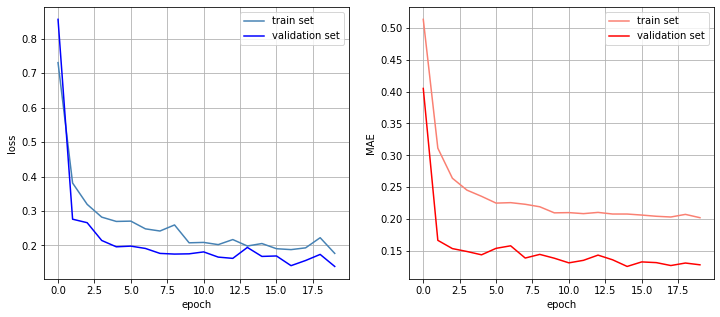

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

axes = axes.flatten()

axes[0].plot(
    history.epoch,
    history.history['loss'],
    color='steelblue',
    label='train set'
)
axes[0].plot(
    history.epoch,
    history.history['val_loss'],
    color='blue',
    label='validation set'
)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    history.epoch,
    history.history['mean_absolute_error'],
    color='salmon',
    label='train set'
)
axes[1].plot(
    history.epoch,
    history.history['val_mean_absolute_error'],
    color='red',
    label='validation set'
)
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('epoch')
axes[1].legend()
axes[1].grid(True)

plt.show();

## Получение значений MAPE

### Валидационная выборка

Получить предсказанные значения цены на валидационной выборке.

In [29]:
y_val_pred = price_scaler.inverse_transform(
    net.predict(x_val).reshape(-1, 1)
).flatten()

Получить значение метрики качества.

In [32]:
mape, percentage = mean_absolute_percentage_error(y_val.values, y_val_pred)

Отобразить диаграмму процентов отклонений для каждого случая.

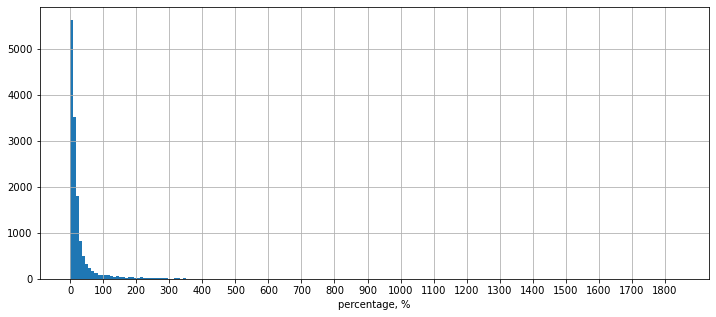

In [42]:
_, axes = plt.subplots(figsize=(12, 5))

plt.hist(percentage, bins=200)
plt.xlabel("percentage, %")
plt.xticks(np.arange(0, percentage.max(), 100))
plt.grid(True)

plt.show();

Отобразить значение MAPE для валидационной выборки:

In [40]:
print(f"MAPE = {mape:.5f} %")

MAPE = 26.96211 %


### Тестовая выборка

Получить предсказанные значения цены на тестовой выборке.

In [43]:
y_test_pred = price_scaler.inverse_transform(
    net.predict(x_test).reshape(-1, 1)
).flatten()

Получить значение метрики качества.

In [44]:
mape, percentage = mean_absolute_percentage_error(y_test.values, y_test_pred)

Отобразить диаграмму процентов отклонений для каждого случая.

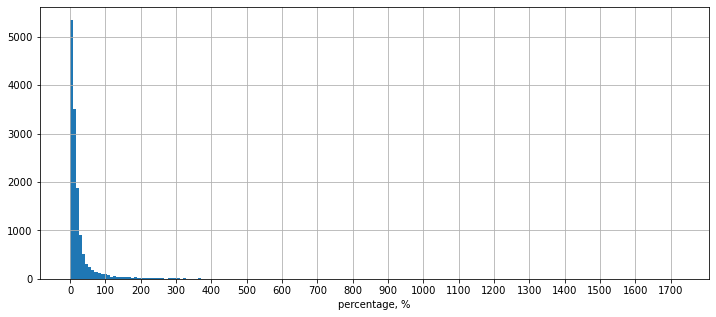

In [45]:
_, axes = plt.subplots(figsize=(12, 5))

plt.hist(percentage, bins=200)
plt.xlabel("percentage, %")
plt.xticks(np.arange(0, percentage.max(), 100))
plt.grid(True)

plt.show();

Отобразить значение MAPE для тестовой выборки:

In [46]:
print(f"MAPE = {mape:.5f} %")

MAPE = 27.15766 %
